In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import utils

from traitlets.config.loader import Config
from astropy.coordinates     import SkyCoord
from lstchain.io.config      import get_standard_config
from ctapipe.io              import read_table

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/scripts"))
import auxiliar as aux
import geometry as geom

# Some configurations

In [2]:
# Source specifications
source_name = "crab"

# Maybe we add a way to extract the run numbers we are interested in
run_numbers = [6172] # [6172, 6242, 6194, 6193, 15337, 15272, 15339, 15340] # [15272] # [15337, 15272]

# Paths to data and results

In [3]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/lst_pipeline/"
# Path to store the configuration file we are going to use
config_file = root + "objects/standard_config.json"
# Data main directory
root_data = root + f"../data/cosmic_ray_data_correction/{source_name}/"

# STANDARD paths ---------
# DL1 data root
dl1_root = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
# RFs root main directory
rfs_root = "/fefs/aswg/data/models/AllSky/20230901_v0.10.4_allsky_base_prod/"
# MCs dl2 main directory
mcs_root = "/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/"


# directories for the data
dir_dl1b = root_data + "dl1b/"
dir_dl2  = root_data + "dl2/"
dir_dl3  = root_data + "dl3/"
dir_irfs = root_data + "irfs/"


# Creating the directories in case they don't exist
for path in [os.path.dirname(config_file), dir_dl1b, dir_dl2, dir_dl3, dir_irfs]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

# Opening and storing configuration file

In [4]:
config_dict = get_standard_config()
# print(config_dict)

#-------------------
# Changes in the configuration should be done here

# We select the heuristic flatfield option in the standard configuration
config_dict["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True

#-------------------

with open(config_file, 'w') as json_file:
    json.dump(config_dict, json_file)

# Finding the files that interest us
#### Extracting dl1 files and dl1 datachecks

In [5]:
# Getting coordinates of source
source_coords = SkyCoord.from_name(source_name)

dict_source = {
    "name"   : source_name,
    "coords" : source_coords,
    "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
    "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
}

# We create a empty dictionary to store all the information needed inside
DICT = {}
for run in run_numbers:
    DICT[run] = {
        "run_num" : run,
        "errors"  : "", # log of errors trough the analysis
    }

DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root)
DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root, dchecking=True)


Adding dl1  data to dictionary...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary...
...Finished adding dl1 data to dictionary


#### Then we read the observations information and also the selected nodes for MC and RFs and we add it to the DICT

In [6]:
%%time
for run in run_numbers:

    tab = read_table(DICT[run]["dchecks"]["runwise"], "/dl1datacheck/cosmics")
    
    # reading the variables
    _zd,     _az       = 90 - np.rad2deg(np.array(tab["mean_alt_tel"])), np.rad2deg(np.array(tab["mean_az_tel"]))
    _t_start, _t_elapsed = tab["dragon_time"][0][0],                       np.array(tab["elapsed_time"])
    
    DICT[run]["time"] = {
        "tstart"   : _t_start,            # datetime object
        "telapsed" : np.sum(_t_elapsed),  # s
        "srunwise" : {
            "telapsed" : _t_elapsed,      # s      
        },
    }
    DICT[run]["pointing"] = {
        "zd" : np.mean(_zd),  # deg
        "az" : np.mean(_az),  # deg
        "srunwise" : {
            "zd" : _zd,       # deg
            "az" : _az,       # deg
        },
    }
    
# then we also select the RFs and MC files looking at the nodes available
DICT, dict_nodes = utils.add_mc_and_rfs_nodes(DICT, rfs_root, mcs_root, dict_source)

CPU times: user 197 ms, sys: 111 ms, total: 308 ms
Wall time: 1.89 s


### Reference fit information

In [54]:
reference_rates = 1.74 
reference_intensity = 422
reference_power_index = -2.23

def plaw(I, A, alpha):
    return  A * (I / reference_intensity) ** alpha

def likelihood_plaw(params, x, y):
    A, k = params[0], params[1]
    y_pred = plaw(x, A, k)
    return np.sum((y - y_pred)**2)

def horizontal_dist_plaws(refpoint, AR, alphaR, A2, alpha2):

    refrate = plaw(refpoint, AR, alphaR)

    def plaw2(x):
        return plaw(x, A2, alpha2) - refrate
        
    sol = optimize.root(plaw2, x0=reference_intensity, method='hybr').x
    
    dist = refpoint - sol
    
    return dist[0]

# Reading DL1a (?)

In [46]:
from lstchain.io.io import dl1_params_lstcam_key, dl1_images_lstcam_key
from lstchain.io.io import dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_tel_mon_flat_key
from scipy.optimize import minimize
from scipy import optimize

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family']      = 'STIXGeneral'
plt.rcParams['mathtext.rm']      = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it']      = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf']      = 'Bitstream Vera Sans:bold'
plt.rcParams['font.size']        = 15

total_bins = np.linspace(1.1, 5, 200)
delta_extending_region = 1.4
delta_extending_region = 1.6526124630784766 + 0.4

lims_intensity = [316, 562]
lims_intensity_ext = [60, lims_intensity[1] * 1]


dl1_file = DICT[run]["dl1a"]["srunwise"][0]

table_total_dl1 = read_table(dl1_file, dl1_params_lstcam_key)
table_cut_dl1   = table_total_dl1[(table_total_dl1["intensity"] >= lims_intensity_ext[0]) & (table_total_dl1["intensity"] <= lims_intensity_ext[1])][:4000]

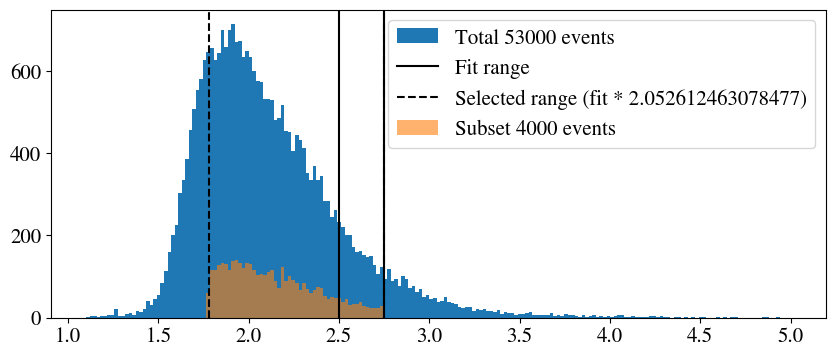

In [11]:
plt.figure(figsize=(10,4))
plt.hist(table_total_dl1["log_intensity"], total_bins, label=f"Total {len(table_total_dl1)} events")
plt.axvline(np.log10(lims_intensity[0]), color="k", label="Fit range")
plt.axvline(np.log10(lims_intensity[1]), color="k")
plt.axvline(np.log10(lims_intensity_ext[0]), color="k", ls="--", label=f"Selected range (fit * {delta_extending_region})")
plt.axvline(np.log10(lims_intensity_ext[1]), color="k", ls="--")

plt.hist(table_cut_dl1["log_intensity"], total_bins, histtype="stepfilled", alpha=0.6, label=f"Subset {len(table_cut_dl1)} events")
plt.legend()
plt.show()

In [12]:
base = "/fefs/aswg/workspace/juan.jimenez/data/cosmic_ray_data_correction/crab/dl1b/02114/"
dl1b_1 = read_table(base+"dl1_LST-1.Run02114.0078_s1.0000.h5", dl1_params_lstcam_key)
dl1b_2 = read_table(base+"dl1_LST-1.Run02114.0078_s1.3266.h5", dl1_params_lstcam_key)

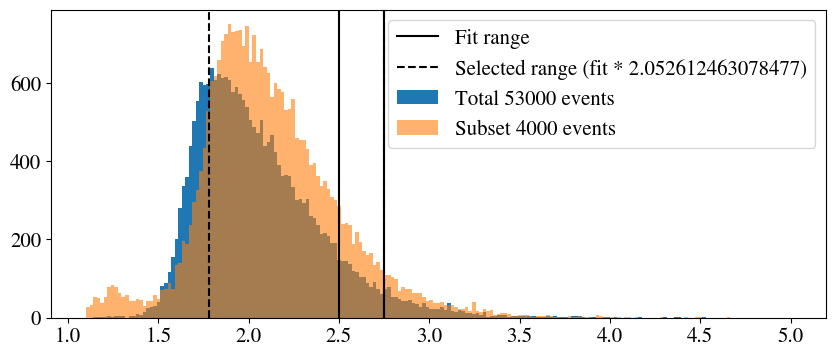

In [13]:
plt.figure(figsize=(10,4))
plt.axvline(np.log10(lims_intensity[0]), color="k", label="Fit range")
plt.axvline(np.log10(lims_intensity[1]), color="k")
plt.axvline(np.log10(lims_intensity_ext[0]), color="k", ls="--", label=f"Selected range (fit * {delta_extending_region})")
plt.axvline(np.log10(lims_intensity_ext[1]), color="k", ls="--")

plt.hist(dl1b_1["log_intensity"], total_bins, label=f"Total {len(table_total_dl1)} events")
plt.hist(dl1b_2["log_intensity"], total_bins, histtype="stepfilled", alpha=0.6, label=f"Subset {len(table_cut_dl1)} events")
plt.legend()
plt.show()

In [375]:
dir_objects = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/analysis_weather/objects"
with open(dir_objects + "/data_dict.pkl", 'rb') as f:
    dict_dcheck = pickle.load(f)  

In [378]:
run = run_numbers[0]
srun = 0

index_run  = list(dict_dcheck["run"]).index(run)
lightyield = dict_dcheck["light_yield"][index_run]
telapsed   = dict_dcheck["telapsed"][index_run]

1/lightyield

1.6526124630784766

In [ ]:
#







#

In [ ]:
reference_rates = 1.74 
reference_intensity = 422
reference_power_index = -2.23

def plaw(I, A, alpha):
    return  A * (I / reference_intensity) ** alpha

def likelihood_plaw(params, x, y):
    A, k = params[0], params[1]
    y_pred = plaw(x, A, k)
    return np.sum((y - y_pred)**2)

def horizontal_dist_plaws(refpoint, AR, alphaR, A2, alpha2):

    refrate = plaw(refpoint, AR, alphaR)

    def plaw2(x):
        return plaw(x, A2, alpha2) - refrate
        
    sol = optimize.root(plaw2, x0=reference_intensity, method='hybr').x
    
    dist = refpoint - sol
    
    return dist[0]

In [335]:
%%time
run = run_numbers[0]
srun = 0
# 1, 1.4141, 1.20706
input_fname  = DICT[run]["dl1a"]["srunwise"][srun]

output_fname = f"dl1_LST-1.Run{run:05}.{srun:04}_test_1.h5"

!lstchain_dl1ab \
  -f $input_fname \
  -o $output_fname \
  -c $config_file \
  --no-image \
  --light-scaling $1

Pedestal cleaning
Fraction of pixel cleaning thresholds above picture thr.:0.030
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from image pixels which have charge below = 0.03 * average size
Pedestal cleaning
Fraction of pixel cleaning thresholds above picture thr.:0.030
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from image pixels which have charge below = 0.03 * average size
Pedestal cleaning
Fraction of pixel cleaning thresholds above pictur

In [350]:
dl1b_df_total1 = read_table(f"dl1_LST-1.Run{run:05}.{srun:04}_test_1.h5", dl1_params_lstcam_key)
dl1b_df_sub1   = read_table(f"dl1_LST-1.Run{run:05}.{srun:04}_onlyrange_1.h5", dl1_params_lstcam_key)

In [354]:
limsint = [316, 562]
total_bins  = np.linspace(4, 6000, 400)
bins_c      = (total_bins[1:] + total_bins[:-1]) / 2
bin_size    = np.diff(total_bins)
mask_bins = []
for b in bins_c:
    if b >= limsint[0] and b <= limsint[1]:
        mask_bins.append(True)
    else:
        mask_bins.append(False)
bins_space = np.linspace(limsint[0]-100, limsint[1]+200, 100)

hist_tot_1, _ = np.histogram(dl1b_df_total1["intensity"], total_bins)
hist_lim_1, _ = np.histogram(dl1b_df_sub1["intensity"], total_bins)

rate_tot_1 = hist_tot_1 / telapsed / bin_size
rate_lim_1 = hist_lim_1 / telapsed / bin_size

result_1 = minimize(likelihood_plaw, x0=[reference_rates, reference_power_index], args=(bins_c[mask_bins], rate_lim_1[mask_bins]))
a_1, p_index_1 = result_1.x

intensity_disp_1 = horizontal_dist_plaws(reference_intensity, reference_rates, reference_power_index, a_1, p_index_1)

ly1 = ((reference_intensity - intensity_disp_1)/ reference_intensity)

In [359]:
%%time
print(ly1, 1/ly1, (1+1/ly1)/2)
output_fname = f"dl1_LST-1.Run{run:05}.{srun:04}_test_2.h5"

scale = 1/ly1

!lstchain_dl1ab \
  -f $input_fname \
  -o $output_fname \
  -c $config_file \
  --no-image \
  --light-scaling $scale

output_fname = f"dl1_LST-1.Run{run:05}.{srun:04}_test_3.h5"

scale = (1+1/ly1)/2

!lstchain_dl1ab \
  -f $input_fname \
  -o $output_fname \
  -c $config_file \
  --no-image \
  --light-scaling $scale

0.7071495102123088 1.4141281094853169 1.2070640547426583
Pedestal cleaning
Fraction of pixel cleaning thresholds above picture thr.:0.030
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from image pixels which have charge below = 0.03 * average size
CPU times: user 1.84 s, sys: 430 ms, total: 2.27 s
Wall time: 2min 7s


In [360]:
dl1b_df_sub2 = read_table(f"dl1_LST-1.Run{run:05}.{srun:04}_onlyrange_2.h5", dl1_params_lstcam_key)
dl1b_df_sub3 = read_table(f"dl1_LST-1.Run{run:05}.{srun:04}_onlyrange_3.h5", dl1_params_lstcam_key)

dl1b_df_total2 = read_table(f"dl1_LST-1.Run{run:05}.{srun:04}_test_2.h5", dl1_params_lstcam_key)
dl1b_df_total3 = read_table(f"dl1_LST-1.Run{run:05}.{srun:04}_test_3.h5", dl1_params_lstcam_key)

In [361]:
hist_tot_2, _ = np.histogram(dl1b_df_total2["intensity"], total_bins)
hist_tot_3, _ = np.histogram(dl1b_df_total3["intensity"], total_bins)
hist_lim_2, _ = np.histogram(dl1b_df_sub2["intensity"], total_bins)
hist_lim_3, _ = np.histogram(dl1b_df_sub3["intensity"], total_bins)

rate_tot_2 = hist_tot_2 / telapsed / bin_size
rate_tot_3 = hist_tot_3 / telapsed / bin_size
rate_lim_2 = hist_lim_2 / telapsed / bin_size
rate_lim_3 = hist_lim_3 / telapsed / bin_size

result_2 = minimize(likelihood_plaw, x0=[reference_rates, reference_power_index], args=(bins_c[mask_bins], rate_lim_2[mask_bins]))
a_2, p_index_2 = result_2.x
result_3 = minimize(likelihood_plaw, x0=[reference_rates, reference_power_index], args=(bins_c[mask_bins], rate_lim_3[mask_bins]))
a_3, p_index_3 = result_3.x

intensity_disp_2 = horizontal_dist_plaws(reference_intensity, reference_rates, reference_power_index, a_2, p_index_2)
intensity_disp_3 = horizontal_dist_plaws(reference_intensity, reference_rates, reference_power_index, a_3, p_index_3)

ly2 = ((reference_intensity - intensity_disp_2)/ reference_intensity)
ly3 = ((reference_intensity - intensity_disp_3)/ reference_intensity)

In [364]:
intensity_disp_2

22.133050265768702

In [374]:
1/((reference_intensity - intensity_disp_2)/reference_intensity)**((p_index_2)/(1+p_index_2))

1.1041688107992236

[]

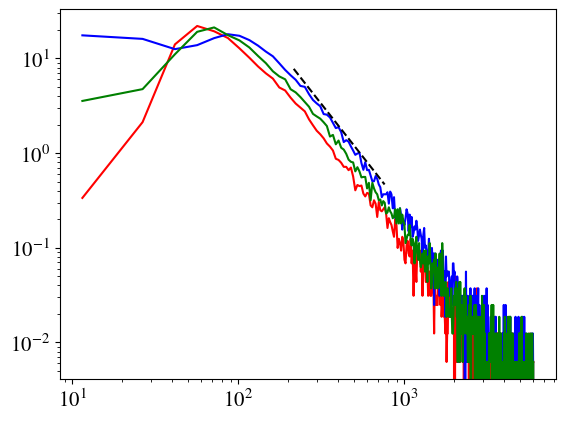

In [363]:
# plt.plot(bins_c, rate_lim_1, color="r")
# plt.plot(bins_c, rate_lim_2, color="b")
# plt.plot(bins_c, rate_lim_3, color="g")

plt.plot(bins_c, rate_tot_1, color="r")
plt.plot(bins_c, rate_tot_2, color="b")
plt.plot(bins_c, rate_tot_3, color="g")

plt.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--")

plt.loglog()

# Scheme plots

In [349]:
1/ly3

1.201922213295759

In [337]:


pol2 = np.poly1d(np.polyfit([1, (1 + 1/ly1)/2, 1/ly1], [ly1, ly3, ly2], 2))
sol  = optimize.root(pol2 - 1, x0=(1 + 1/ly1)/2, method='hybr').x[0]

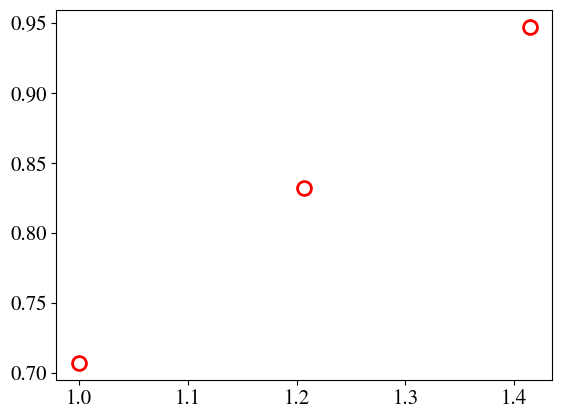

In [339]:
plt.plot([1, (1 + 1/ly1)/2, 1/ly1], [ly1, ly3, ly2], color="r", marker="o", ms=10, mfc="w", markeredgewidth=2, ls="")

In [ ]:
input_fname  = DICT[run]["dl1a"]["srunwise"][srun]
output_fname = f"dl1_LST-1.Run{run:05}.{srun:04}_test_f.h5"

!lstchain_dl1ab \
  -f $input_fname \
  -o $output_fname \
  -c $config_file \
  --no-image \
  --light-scaling $1.30875

In [327]:
dl1b_df_totalf    = read_table(f"dl1_LST-1.Run{run:05}.{srun:04}_test_f.h5", dl1_params_lstcam_key)

hist_tot_f, _ = np.histogram(dl1b_df_totalf["intensity"], total_bins)
rate_tot_f = hist_tot_f / telapsed / bin_size

result_f = minimize(likelihood_plaw, x0=[reference_rates, reference_power_index], args=(bins_c[mask_bins], rate_tot_f[mask_bins]))
a_f, p_index_f = result_f.x

intensity_disp_f = horizontal_dist_plaws(reference_intensity, reference_rates, reference_power_index, a_f, p_index_f)

lyf = ((reference_intensity - intensity_disp_f)/ reference_intensity)

1.3082179040994877

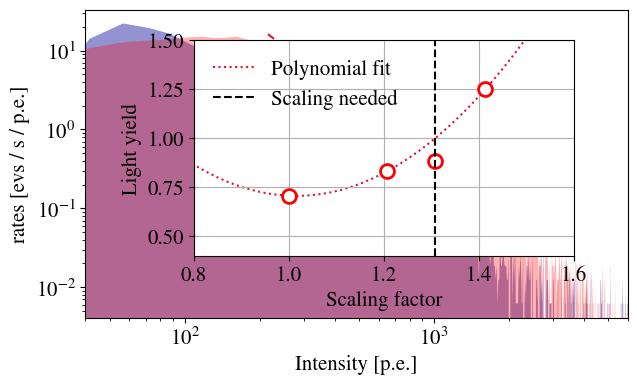

In [330]:
fig, ax = plt.subplots(figsize=(7,4))

# PLOT 1
# ax.fill_between(bins_c, rate_tot_1, label=f"Total {len(table_total_dl1)} evs", color="lightgray",lw=0)
# ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--", label="Reference")
# ax.axvspan(lims_intensity[0], lims_intensity[1], alpha=0.3, ls="-", facecolor="none", hatch="///", edgecolor="k", label="Fit range")
# ax.axvline((lims_intensity_ext[0]), color="k", ls=":", label="Extended range")
# ax.legend(loc=1)

# PLOT 2
# ax.fill_between(bins_c, rate_tot_1, label=f"Total {len(dl1b_df_total)} evs", color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--")
# ax.axvspan(lims_intensity[0], lims_intensity[1], alpha=0.3, ls="-", facecolor="none", hatch="///", edgecolor="k",)
# ax.axvline((lims_intensity_ext[0]), color="k", ls=":",)
# ax.legend(loc=1)

# PLOT 3
# ax.fill_between(bins_c, rate_tot_1, label=f"Total {len(dl1b_df_total)} evs", color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--")
# ax.plot(bins_space, plaw(bins_space, a_1, p_index_1), color="mediumblue", ls="--", label="Power Law fit")
# ax.axvspan(lims_intensity[0], lims_intensity[1], alpha=0.3, ls="-", facecolor="none", hatch="///", edgecolor="k",)
# ax.axvline((lims_intensity_ext[0]), color="k", ls=":",)
# ax.legend(loc=1)

# PLOT 4
# ax.fill_between(bins_c, rate_tot_1, label=f"Total {len(dl1b_df_total)} evs", color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--")
# ax.plot(bins_space, plaw(bins_space, a_1, p_index_1), color="mediumblue", ls="--", label="Power Law fit")
# ax.axvline(reference_intensity, color="k", ls=":", label="422 p.e.")
# ax.scatter([reference_intensity/2 + (reference_intensity-intensity_disp_1)/2 - 18], [reference_rates], 
#            c='r', marker=r'$\rightarrow$', s=600, label="Light Yield", zorder=10)
# ax.legend(loc=1)

# PLOT 5
# ax.fill_between(bins_c, rate_tot_1, label=f"Total {len(dl1b_df_total)} evs", color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--")
# ax.plot(bins_space, plaw(bins_space, a_1, p_index_1), color="mediumblue", ls="--", label="Power Law fit")
# ax.axvline(reference_intensity, color="k", ls=":", label="422 p.e.")
# ins = ax.inset_axes([0.2,0.2,0.7,0.7])
# ins.plot([1], [ly1], color="b", marker="o", ms=10, mfc="w", markeredgewidth=2)
# ins.set_xlabel("Scaling factor")
# ins.set_ylabel("Light yield")
# ins.grid(color="gray")
# ins.set_ylim(0.4, 1.5)
# ins.set_xlim(0.8, 1.6)

# PLOT 6
# ax.fill_between(bins_c, rate_tot_1, color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.legend(loc=1)

# PLOT 7
# ax.fill_between(bins_c, rate_tot_1, color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.fill_between(bins_c, rate_lim_2, label=f"Subset scaled LY", color="r", alpha=0.3, lw=0)
# ax.legend(loc=1)

# PLOT 8
# ax.fill_between(bins_c, rate_tot_1, color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.fill_between(bins_c, rate_lim_2, label=f"Subset scaled LY", color="r", alpha=0.3, lw=0)

# ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--")
# ax.plot(bins_space, plaw(bins_space, a_2, p_index_2), color="crimson", ls="--", label="Scaled Power fit")

# ax.axvspan(lims_intensity[0], lims_intensity[1], alpha=0.3, ls="-", facecolor="none", hatch="///", edgecolor="k",)
# ax.legend(loc=1)

# PLOT 9
# ax.fill_between(bins_c, rate_tot_1, color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.fill_between(bins_c, rate_lim_2, label=f"Subset scaled LY", color="r", alpha=0.3, lw=0)

# ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--", label="Reference")
# ax.plot(bins_space, plaw(bins_space, a_2, p_index_2), color="crimson", ls="--", label="Scaled Power fit")
# ax.scatter([reference_intensity/2 + (reference_intensity-intensity_disp_2)/2-20], [reference_rates], 
#            c='r', marker=r'$\leftarrow$', s=500, label="Light Yield", zorder=10)
# ax.legend(loc=1)

# PLOT 9
# ax.fill_between(bins_c, rate_tot_1, color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.fill_between(bins_c, rate_lim_2, label=f"Subset scaled LY", color="r", alpha=0.3, lw=0)
# ax.fill_between(bins_c, rate_lim_3, label=f"Subset scaled LY", color="g", alpha=0.3, lw=0)
# ax.fill_between(bins_c, rate_tot_f, label=f"Subset scaled LY", color="k", alpha=0.3, lw=0)

# ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--", label="Reference")
# ax.plot(bins_space, plaw(bins_space, a_2, p_index_2), color="crimson", ls="--", label="Scaled Power fit")
# ax.scatter([reference_intensity/2 + (reference_intensity-intensity_disp_2)/2-20], [reference_rates], 
#            c='r', marker=r'$\leftarrow$', s=500, label="Light Yield", zorder=10)
# ax.legend(loc=1)

# PLOT 10
ax.fill_between(bins_c, rate_tot_1, color="lightgray", lw=0)
ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
ax.fill_between(bins_c, rate_lim_2, label=f"Subset scaled LY", color="r", alpha=0.3, lw=0)

ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--")
ax.plot(bins_space, plaw(bins_space, a_2, p_index_2), color="crimson", ls="--", label="Scaled Power fit")

ins = ax.inset_axes([0.2,0.2,0.7,0.7])
ins.plot([1, (1 + 1/ly1)/2, 1/ly1, sol], [ly1, ly3, ly2, lyf], color="r", marker="o", ms=10, mfc="w", markeredgewidth=2, ls="")
ins.set_xlabel("Scaling factor")
ins.set_ylabel("Light yield")
xp = np.linspace(-1, 3, 200)
ins.plot(xp, pol2(xp), ':', color="crimson", label="Polynomial fit", zorder=-10)
ins.axvline(sol, color="k", ls="--", label=f"Scaling needed")
ins.legend(frameon=False)
ins.grid()
ins.set_ylim(0.4, 1.5)
ins.set_xlim(0.8, 1.6)

# PLOT 11
# ax.fill_between(bins_c, rate_tot_1, color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_lim_1, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.fill_between(bins_c, rate_lim_2, label=f"Subset scaled LY", color="r", alpha=0.3, lw=0)

# ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--")
# ax.plot(bins_space, plaw(bins_space, a_2, p_index_2), color="crimson", ls="--", label="Scaled Power fit")

# ins = ax.inset_axes([0.2,0.2,0.7,0.7])
# ins.plot([1, 1/ly1], [ly1, ly2], color="r", marker="o", ms=10, mfc="w", markeredgewidth=2)
# ins.set_xlabel("Scaling factor")
# ins.set_ylabel("Light yield")
# ins.grid()
# ins.axvline(1.228, ls="--", zorder=-10, color="k", label="Factor to\napply: 1.228")
# ins.axhline(1, ls="-", zorder=-10, color="k")
# ins.legend(loc=2, frameon=False)
# ins.set_ylim(0.4, 1.5)
# ins.set_xlim(0.8, 1.6)

# PLOT 9
# ax.fill_between(bins_c, rate_tot_1, color="lightgray", lw=0)
# ax.fill_between(bins_c, rate_tot_3, label=f"Subset", color="mediumblue", alpha=0.3, lw=0)
# ax.fill_between(bins_c, rate_lim_2, label=f"Subset scaled LY", color="r", alpha=0.3, lw=0)

# ax.plot(bins_space, plaw(bins_space, reference_rates, reference_power_index), color="k", ls="--", label="Reference")
# ax.plot(bins_space, plaw(bins_space, a_2, p_index_2), color="crimson", ls="--", label="Scaled Power fit")


# ax.legend(loc=1)


ax.loglog()
ax.set_yscale("log")
ax.set_ylabel("rates [evs / s / p.e.]")
ax.set_xlabel("Intensity [p.e.]")
ax.set_xlim(40, 6000)
# ax.grid(which="both", zorder=-100, alpha=0.3)

plt.show()

In [329]:
1/lyf

1.1323314321794833

In [21]:
result_1 = minimize(likelihood_plaw, x0=[reference_rates, reference_power_index], args=(bins_c[mask_bins], rate_tot_1[mask_bins]))
a_1, p_index_1 = result_1.x

In [ ]:
plt.plot(bins_c[mask_bins], rate_tot_1[mask_bins]);
plt.plot(bins_space, plaw(bins_space, 0.8, p_index_1), color="k", ls="--");

In [ ]:
a_1, p_index_1

# DL1a to DL1b

In [ ]:
print([*np.linspace(1-0.6383, 1, 5)[:-1], *np.linspace(1, 1.6383, 5),*np.linspace(1.6383, 2, 5)[1:]])
scales = 0.840425

In [ ]:
%%time
for ir, run in enumerate(DICT.keys()):

    sruns = [int(path.split(".")[-2]) for path in DICT[run]["dl1a"]["srunwise"]]
    DICT[run]["dl1b"] = {"srunwise" : []}

    for i, srun in enumerate(sruns):

        if i in [0]:
            input_fname  = DICT[run]["dl1a"]["srunwise"][i]
            output_fname = dir_dl1b + f"dl1_LST-1.Run{run:05}.{srun:04}_scaled{scales:.4f}.h5"
    
            print(f"\nComputing dl1b Run {run:5} Subrun {srun:04} - {i/len(sruns)*100:3.1f}% sruns {ir+1}/{len(DICT.keys())} runs")
            print(f"--> {output_fname}\n")
    

    
            DICT[run]["dl1b"]["srunwise"].append(output_fname)

# DL1b to DL2

In [ ]:
%%time
for ir, run in enumerate(DICT.keys()):
            
    sruns = [int(path.split(".")[-2]) for path in DICT[run]["dl1a"]["srunwise"]]
    DICT[run]["dl2"] = {"srunwise" : []}

    for i, srun in enumerate(sruns):
        if i in [0]:
            input_fname  = DICT[run]["dl1b"]["srunwise"][i]
            output_fname = dir_dl2 + f"{run:05}/" + input_fname.split("/")[-1].replace("dl1", "dl2", 1)
            rf_node      = DICT[run]["simulations"]["rf"]
            dir_run      = dir_dl2 + f"{run:05}/"
    
            print(f"\nComputing dl2 Run {run:5} Subrun {srun:04} - {i/len(sruns)*100:3.1f}% sruns {ir+1}/{len(DICT.keys())} runs")
            print(f"--> {output_fname}\n")
    
            !lstchain_dl1_to_dl2 \
              -f $input_fname \
              -p $rf_node \
              -o $dir_run \
              -c $config_file \
    
            DICT[run]["dl2"]["srunwise"].append(output_fname)

# DL2 merging run-wise

In [ ]:

for ir, run in enumerate(DICT.keys()):
    
    output_fname = dir_dl2 + f"dl2_LST-1.Run{run:05}.h5"
    
    !lstchain_merge_hdf5_files \
      -d $dir_dl2 \
      -o $output_fname \
      --run-number $run \
      --no-image \
    
    DICT[run]["dl2"]["runwise"] = output_fname

# MCs to IRFs

In [ ]:
%%time
# Already computed IRFs
computed_irfs = glob.glob(dir_irfs + "*")

for ir, run in enumerate(DICT.keys()):
    
    output_fname = dir_dl2 + f"dl2_LST-1.Run{run:05}.h5"
    input_mc = DICT[run]["simulations"]["mc"]

    output_irf = dir_irfs + "irf_{}_{}.fits.gz".format(input_mc.split("/")[-3], input_mc.split("/")[-2])

    # we don't compute the IRF if it has been already done
    if output_irf not in computed_irfs:
        
        print(f"\nComputing IRF for Run {run:5}, {ir+1}/{len(DICT.keys())} runs")
        print(f"--> {output_irf}\n")
        
        !lstchain_create_irf_files \
          --input-gamma-dl2 $input_mc \
          --output-irf-file $output_irf \
          --point-like \
          --energy-dependent-gh \
          --energy-dependent-theta \
          --overwrite \   
    else:
        print("\nIRF {}_{} already computed\n".format(input_mc.split("/")[-3], input_mc.split("/")[-2]))

    DICT[run]["irf"] = output_irf

# DL2 to DL3

In [ ]:
# %%time
# ra_str  = "{}deg".format(dict_source["ra"])
# dec_str = "{}deg".format(dict_source["dec"])
# for ir, run in enumerate(DICT.keys()):

#     dl2_fname = DICT[run]["dl2"]["runwise"]
#     irf_fname = DICT[run]["irf"]
    
#     !lstchain_create_dl3_file \
#       --d $dl2_fname \
#       --i $irf_fname \
#       --o $dir_dl3 \
#       --source-name $source_name \
#       --source-ra  $ra_str \
#       --source-dec $dec_str \
#       --config $config_file \
#       --overwrite \

## Add DL3 index files

In [ ]:
# logger.info(f"All dl3 files created 100%\n\n\nCreating index files...")

# # Creating the index file
# !lstchain_create_dl3_index_files \
# --input-dl3-dir $path_dl3 \
# --file-pattern 'dl3*.fits' \
# --overwrite

# logger.info(f"Finished with the dl3 process")